In [2]:
!pip install NRCLex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=521ef93e4501cf083d029d23c2b1758025a7a01da01c885f2674c74f3001e85a
  Stored in directory: /root/.cache/pip/wheels/d2/10/44/6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built NRCLex


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nrclex import NRCLex
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

In [14]:

from google.colab import files


uploaded = files.upload()

Saving Datav.csv to Datav.csv


In [15]:
import io

df = pd.read_csv(io.BytesIO(uploaded['Datav.csv']))
print(df)

     Unnamed: 0.1  Unnamed: 0  \
0               0           0   
1               1           1   
2               2           2   
3               3           3   
4               4           4   
..            ...         ...   
727           728         732   
728           729         733   
729           730         734   
730           731         735   
731           732         736   

                                                  Text    Sentiment  \
0     Enjoying a beautiful day at the park!        ...   Positive     
1     Traffic was terrible this morning.           ...   Negative     
2     Just finished an amazing workout! 💪          ...   Positive     
3     Excited about the upcoming weekend getaway!  ...   Positive     
4     Trying out a new recipe for dinner tonight.  ...   Neutral      
..                                                 ...          ...   
727  Collaborating on a science project that receiv...       Happy    
728  Attending a surprise birthday 

In [16]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  732 non-null    int64 
 1   Unnamed: 0    732 non-null    int64 
 2   Text          732 non-null    object
 3   Sentiment     732 non-null    object
 4   Timestamp     732 non-null    object
 5   User          732 non-null    object
 6   Platform      732 non-null    object
 7   Hashtags      732 non-null    object
 8   Retweets      732 non-null    int64 
 9   Likes         732 non-null    int64 
 10  Country       732 non-null    object
 11  Year          732 non-null    int64 
 12  Month         732 non-null    int64 
 13  Day           732 non-null    int64 
 14  Hour          732 non-null    int64 
dtypes: int64(8), object(7)
memory usage: 85.9+ KB


In [18]:
df.shape

(732, 15)

In [19]:
df_features = df.select_dtypes(include=[object])

list(df_features.columns)

['Text', 'Sentiment', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Country']

In [20]:
df[list(df_features.columns)] = df[list(df_features.columns)].replace(r'\s+', '', regex=True)

In [21]:
len_duplicated = len(df[df.duplicated(subset=['Text','Timestamp', 'Platform'])])

In [22]:
len(df) - len_duplicated

709

In [23]:
# Rename pudlicated entries and save to a new dataframe

no_duplicated = df.drop_duplicates(subset=['Text','Timestamp', 'Platform'], keep='first')
# Check the lengths to be sure that the cleaning is done correctly

len(no_duplicated)

709

In [24]:
no_duplicated['Platform'].unique()

array(['Twitter', 'Instagram', 'Facebook'], dtype=object)

In [25]:
twitter = no_duplicated[no_duplicated["Platform"] == 'Twitter']
instagram = no_duplicated[no_duplicated["Platform"] == 'Instagram']
facebook = no_duplicated[no_duplicated["Platform"] == 'Facebook']

#Section 3 - Exploratory data analysis¶

1. How many many Twitter, Instagram, and Facebook data the dataset has?


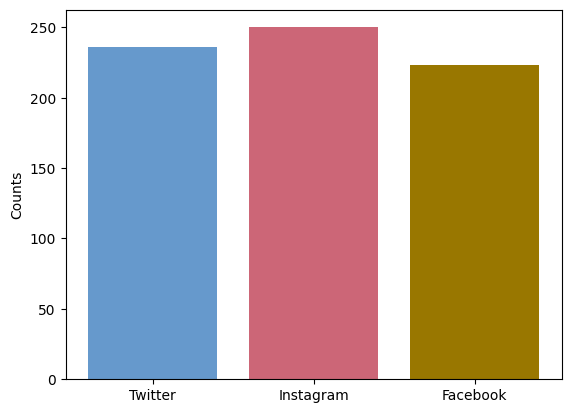

In [26]:
plt.bar(['Twitter', 'Instagram', 'Facebook'],
        [twitter['Text'].count(), instagram['Text'].count(), facebook['Text'].count()],
        color=["#6699CC", '#CC6677', '#997700'])
plt.ylabel('Counts')
plt.show()


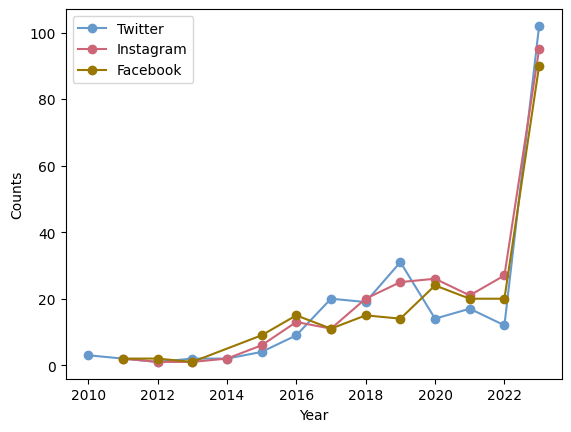

In [27]:
plt.plot(twitter.groupby(['Year']).Platform.count(), color= "#6699CC", marker ='o', label='Twitter')
plt.plot(instagram.groupby(['Year']).Platform.count(), color= "#CC6677", marker ='o', label='Instagram')
plt.plot(facebook.groupby(['Year']).Platform.count(), color= "#997700", marker ='o', label='Facebook')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend()

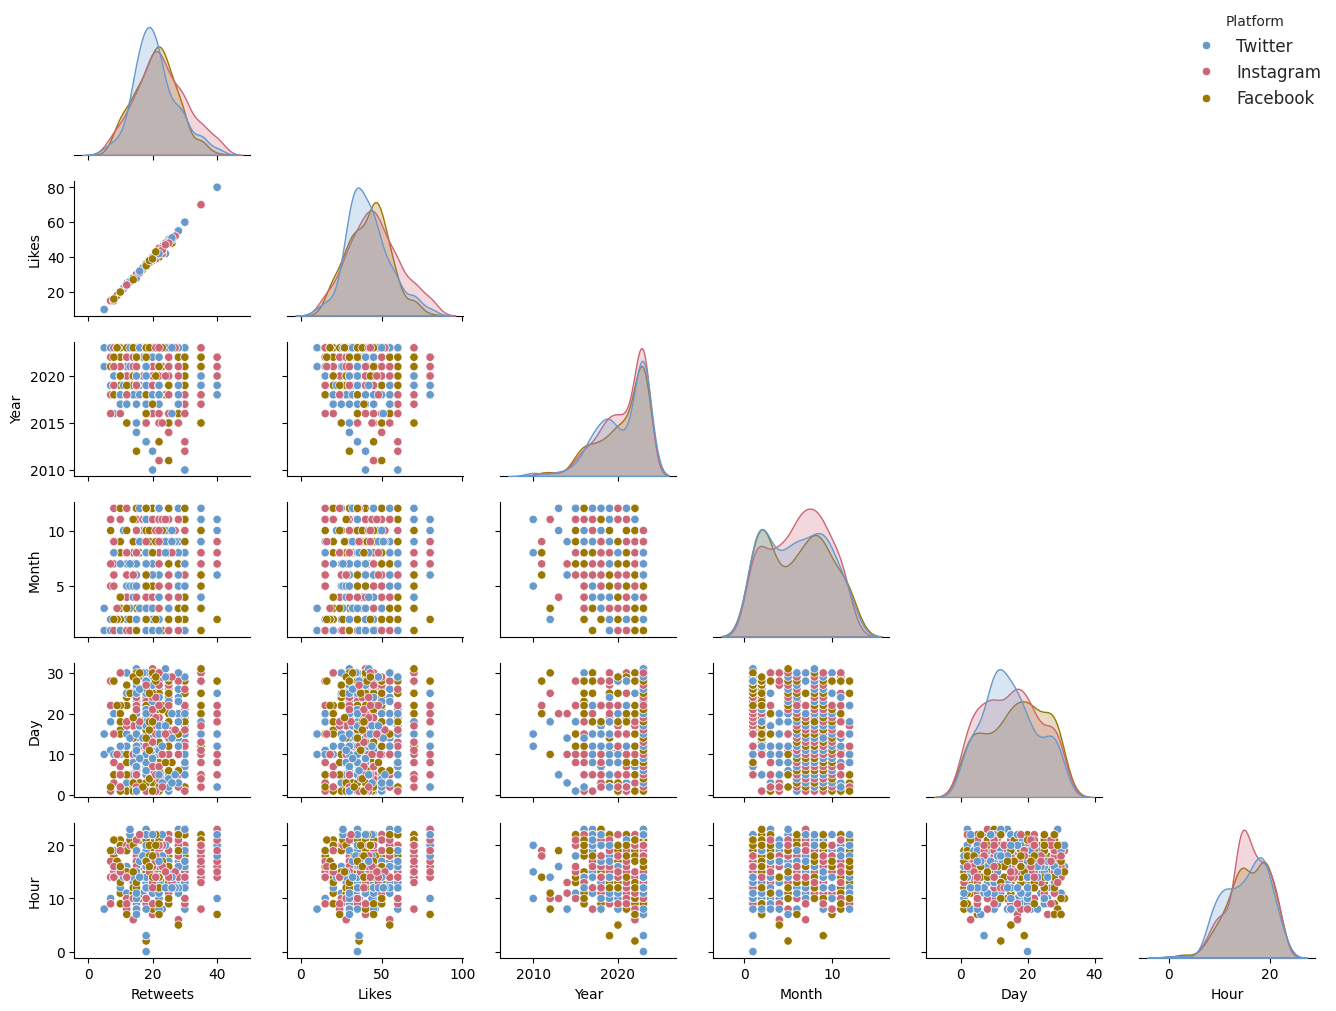

In [28]:
ax = sns.pairplot(no_duplicated[['Platform', 'Retweets', 'Likes', 'Year', 'Month', 'Day', 'Hour']],
                  hue = 'Platform',
                  palette={"Twitter": "#6699CC", "Instagram": "#CC6677", "Facebook": "#997700"},
                  corner=True, height=1.7, aspect=1.2)
sns.set(font_scale=1.1)
sns.move_legend(ax, "upper right")
plt.tight_layout()
plt.show()

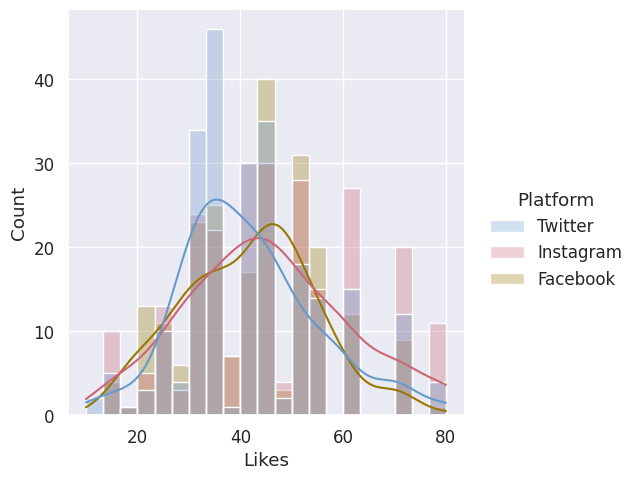

In [29]:
sns.displot(data=no_duplicated[['Platform','Likes']], x="Likes", hue="Platform",
            palette = ["#6699CC", '#CC6677', '#997700'],
            alpha=0.3,
           # multiple='dodge',
           # multiple='stack',
            kde=True)
plt.show()

#Regration model - Prediction of number of retweets

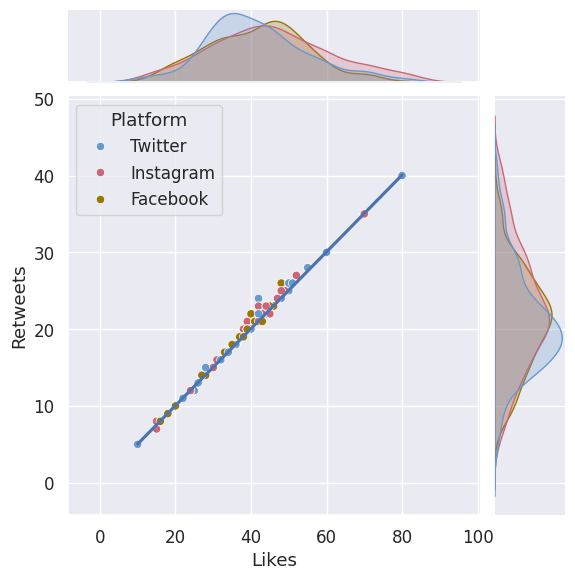

In [30]:

g = sns.jointplot(data=no_duplicated, x="Likes", y="Retweets", hue='Platform',
                  palette={"Twitter": "#6699CC", "Instagram": "#CC6677", "Facebook": "#997700"}, kind="scatter")
g1 = sns.regplot(data=no_duplicated, x="Likes", y="Retweets",
                 scatter=False, ax=g.ax_joint)
#g1 = sns.regplot(data=twitter, x="Likes", y="Retweets", scatter=False, ax=g.ax_joint, line_kws={'linewidth':15, 'ls': '--'})
#g2 = sns.regplot(data=facebook, x="Likes", y="Retweets", scatter=False, ax=g.ax_joint, line_kws={'linewidth':5, 'ls': '-.'})
#g3 = sns.regplot(data=instagram, x="Likes", y="Retweets", scatter=False, ax=g.ax_joint)

regline1 = g1.get_lines()[0]
regline1.set_color('k')
regline1.set_zorder(5)

#regline2 = g2.get_lines()[0]
#regline2.set_color('blue')
#regline2.set_zorder(5)

#regline3 = g3.get_lines()[0]
#regline3.set_color('orange')
#regline3.set_zorder(5)

plt.show()

#Regression formula

In [31]:
model = linear_model.LinearRegression()

# Train the model using the training sets
x = no_duplicated['Likes'].values.reshape((-1, 1))
y = no_duplicated['Retweets'].values

model.fit(x, y)

r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
m = model.coef_[0]
b = model.intercept_

#print(f"intercept: {model.intercept_}")
#print(f"slope: {model.coef_}")
print()
print(f"Regression: y =  {model.intercept_} + {model.coef_[0]} x")

coefficient of determination: 0.9969381166021544

Regression: y =  0.0426070750786991 + 0.5003703494299322 x


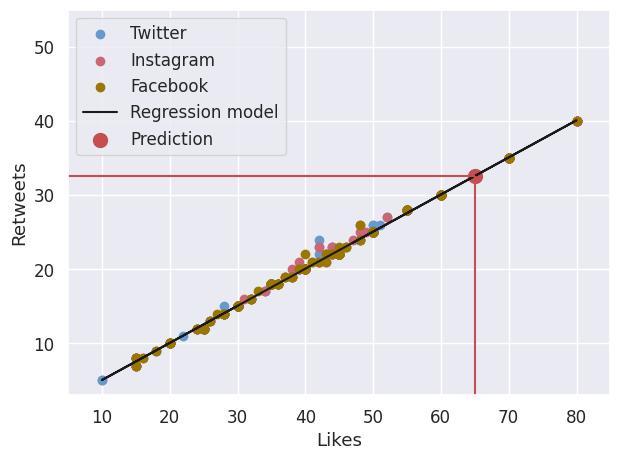

In [32]:
x_pred = 65
plt.scatter(twitter['Likes'], twitter['Retweets'], color='#6699CC', label='Twitter')
plt.scatter(instagram['Likes'], instagram['Retweets'], color='#CC6677', label='Instagram')
plt.scatter(facebook['Likes'], facebook['Retweets'], color='#997700', label='Facebook')

plt.plot(no_duplicated['Likes'], m*no_duplicated['Likes'] + b, 'k', label='Regression model')

plt.scatter(x_pred, model.predict(np.array([[x_pred]]))[0], color = 'r', s=100, label='Prediction')
plt.vlines(x = x_pred, ymin=3, ymax= model.predict(np.array([[x_pred]]))[0], color = 'r', linestyle = '-')
plt.hlines(y = model.predict(np.array([[x_pred]]))[0], xmin= 5, xmax= x_pred, color = 'r', linestyle = '-')
plt.xlim([5, 85])
plt.ylim([3, 55])
plt.legend(loc='best')

plt.xlabel('Likes')
plt.ylabel('Retweets')
plt.tight_layout()
plt.show()


#3. How many likes people n different countries give


In [33]:
no_duplicated.groupby(['Country']).Likes.agg([len, min, max]).sort_values(by='len', ascending=False)

,len,min,max
Country,,,
USA,184,10,80
UK,140,15,70
Canada,131,10,80
Australia,70,15,80
India,67,15,80
Brazil,17,30,80
France,16,35,60
Japan,15,35,70
Germany,14,30,70


In [34]:
no_duplicated.groupby(['Country']).Likes.sum().sort_values(ascending=False)

,Likes
Country,
USA,8184
UK,5727
Canada,5340
Australia,2722
India,2581
Brazil,900
Japan,785
France,740
Germany,675


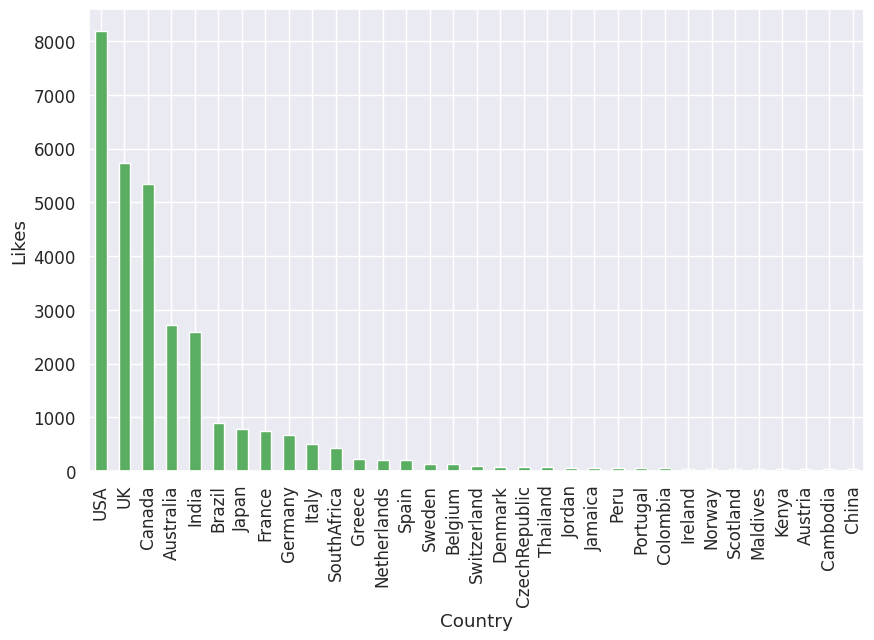

In [35]:
likes_per_country = no_duplicated.groupby(['Country']).Likes.sum().sort_values(ascending=False)

likes_per_country.plot(kind='bar', color = '#5AAE61', figsize=(10, 6) )
plt.ylabel('Likes')
plt.show()

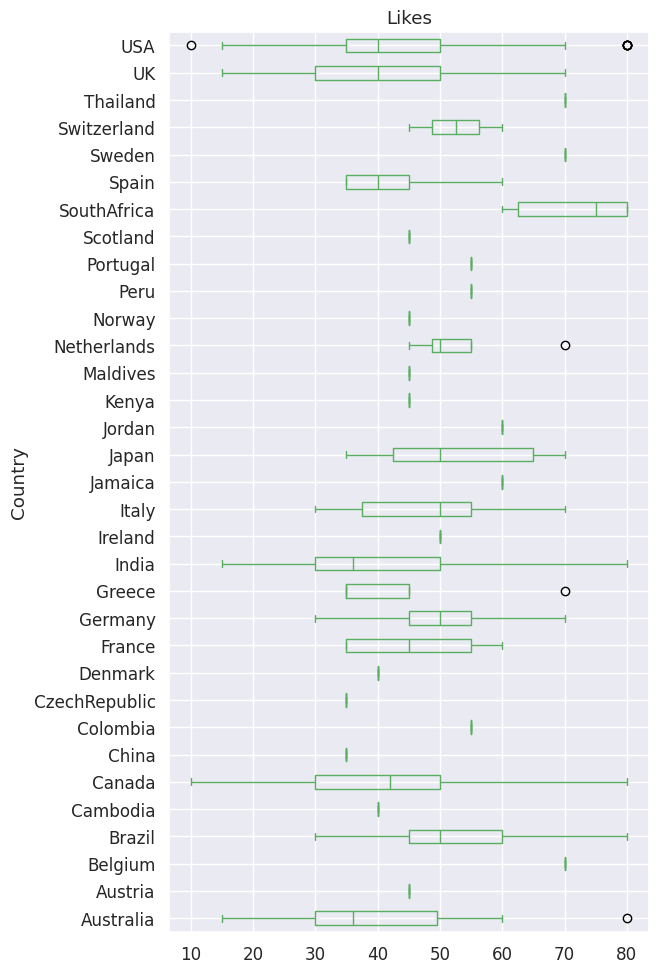

In [36]:
ax = no_duplicated.boxplot(column='Likes', by='Country',
                           #rot=90,
                           color= '#5AAE61',
                           vert=False,
                           figsize=(6, 12) )
ax.get_figure().suptitle("")
plt.show()

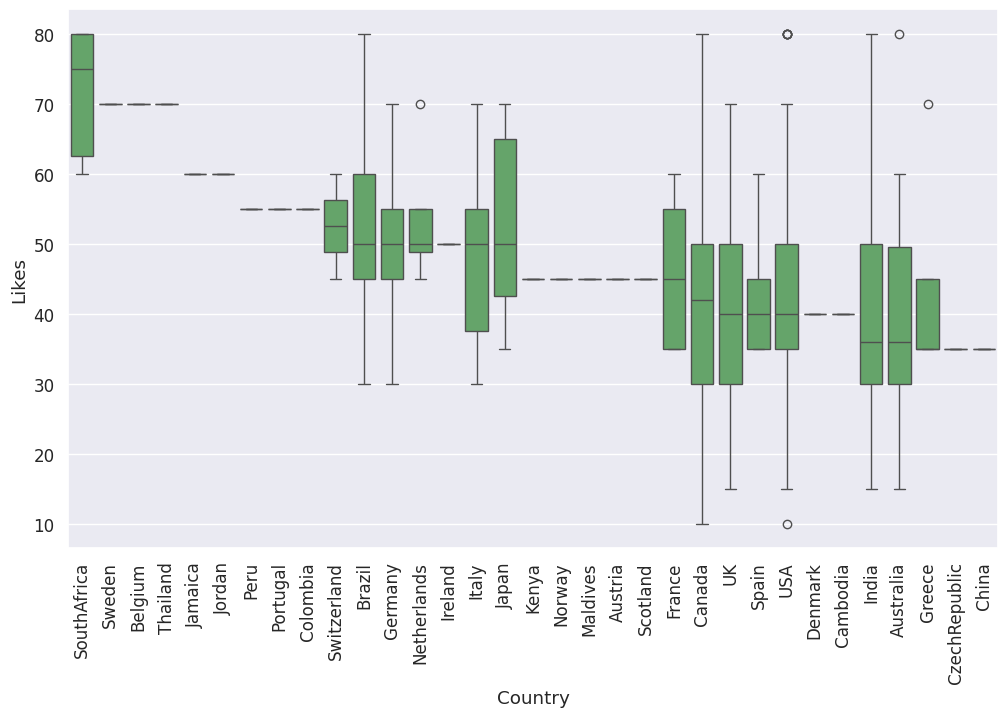

In [37]:
order = no_duplicated.groupby(['Country']).Likes.median().sort_values(ascending=False).index

plt.figure(figsize=(12,7))
g = sns.boxplot(data=no_duplicated, x='Country', y='Likes',
                color ='#5AAE61',
                order=order)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

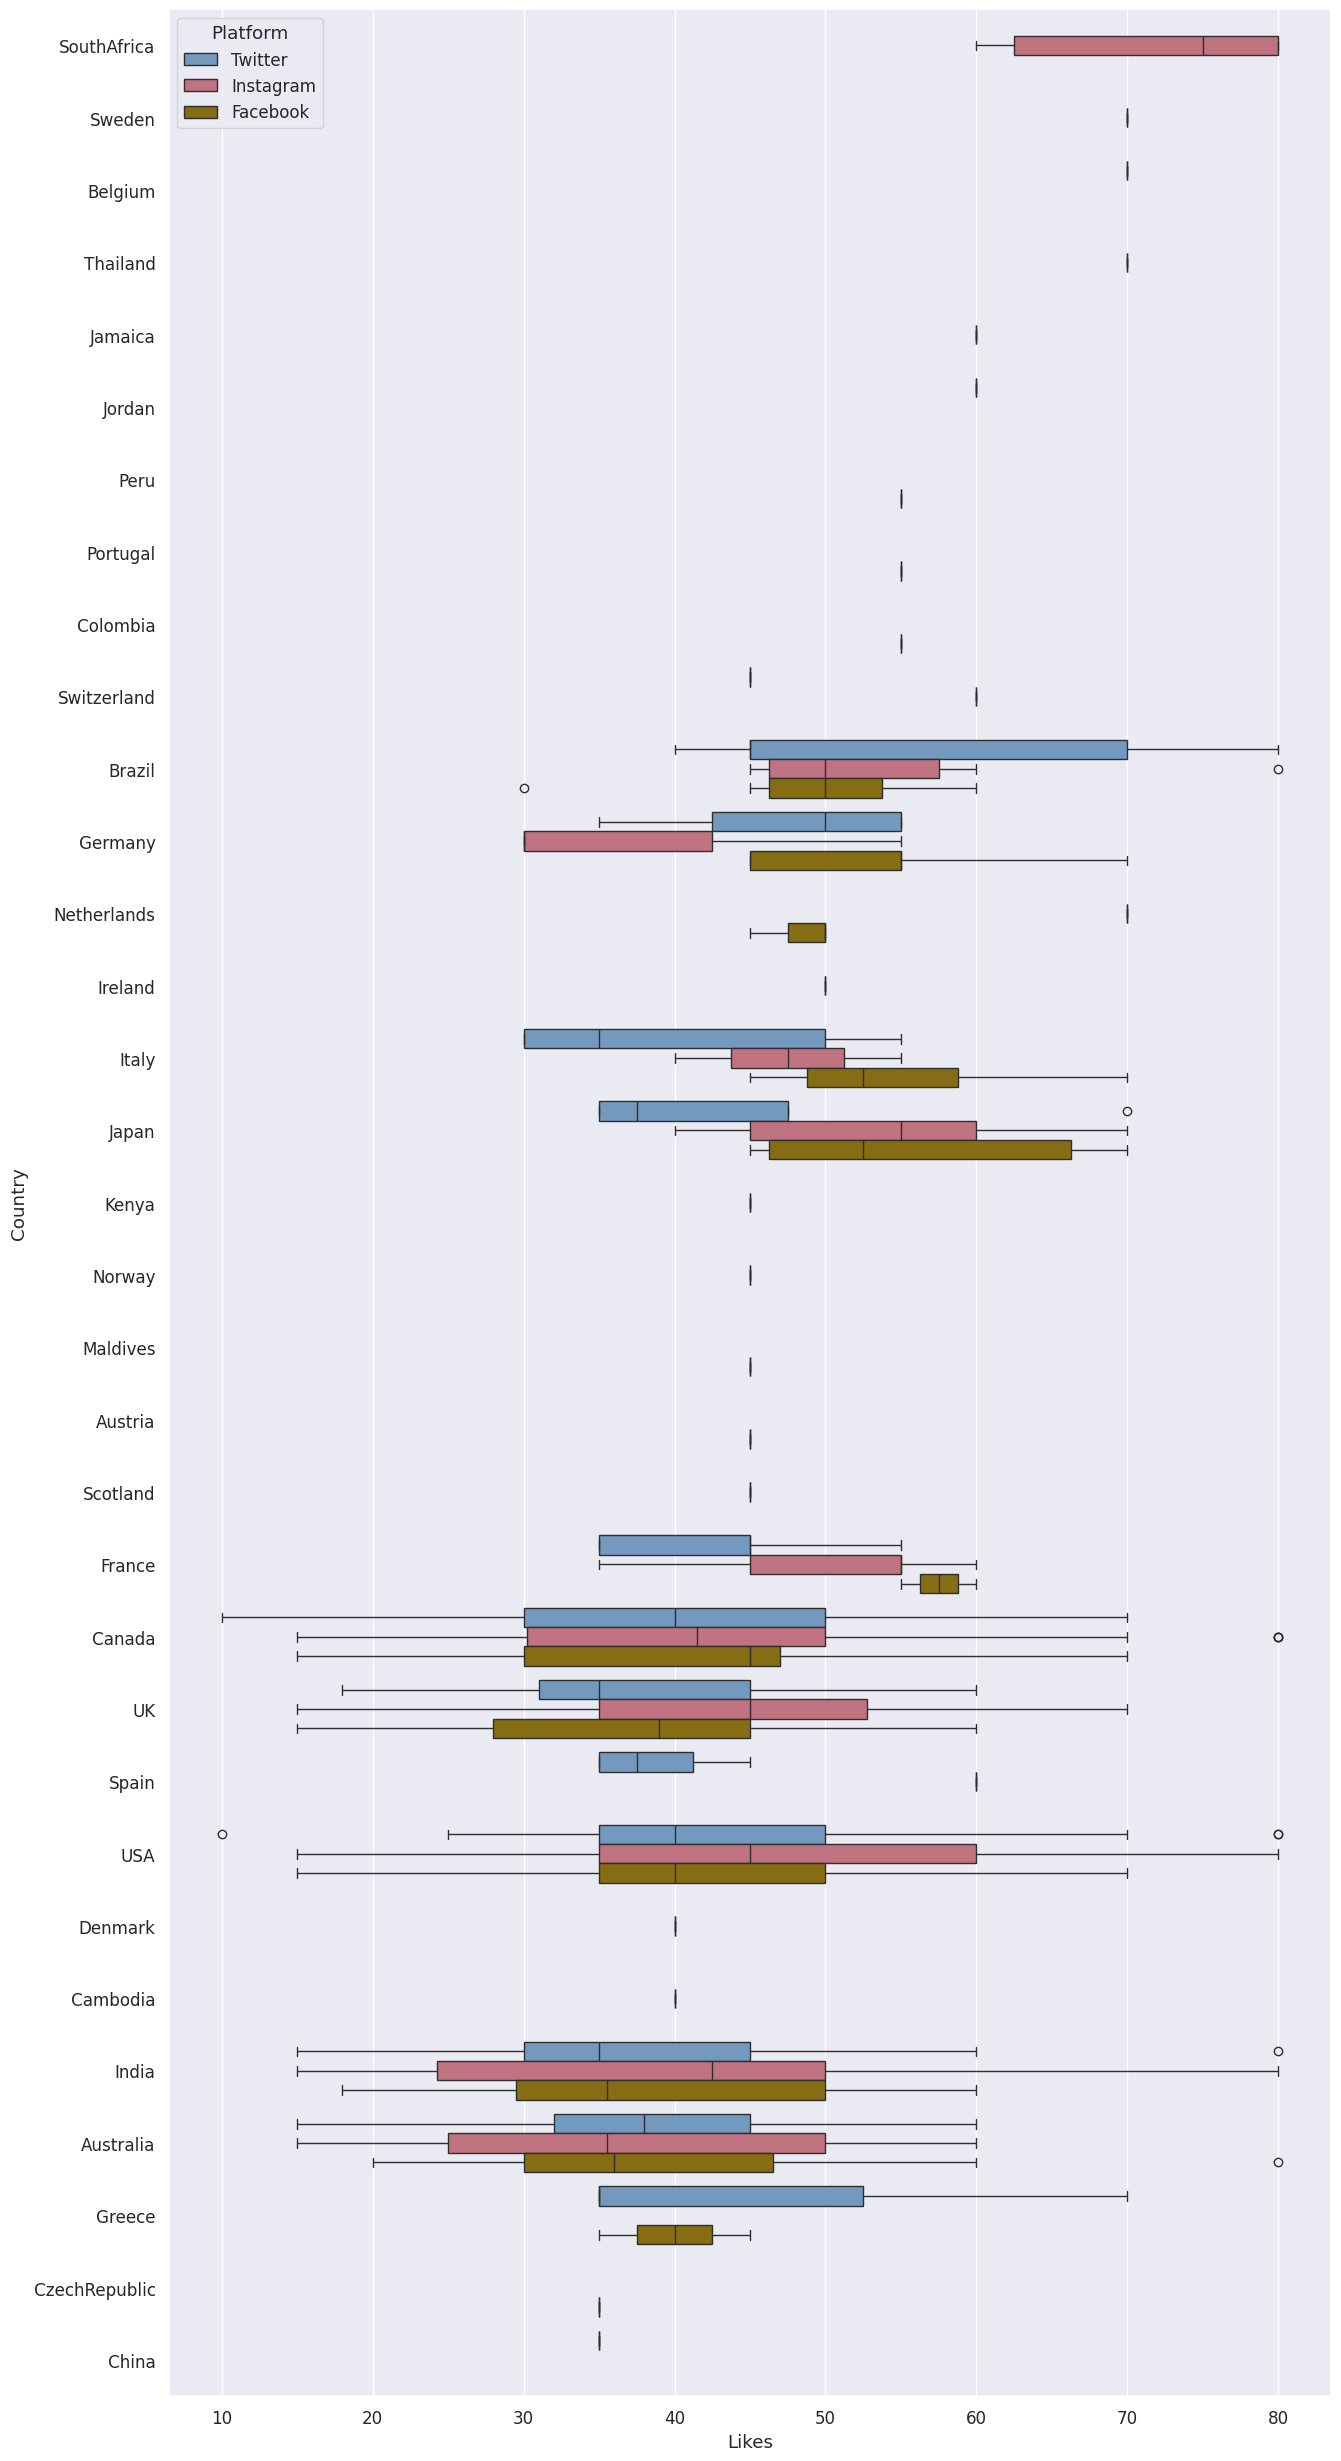

In [38]:
order = no_duplicated.groupby(['Country']).Likes.median().sort_values(ascending=False).index

plt.figure(figsize=(15,31))
g = sns.boxplot(data=no_duplicated, y='Country', x='Likes', hue='Platform',
                palette={"Twitter": "#6699CC", "Instagram": "#CC6677", "Facebook": "#997700"},
                order=order)
#g.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

#4. What emotions have the posts with the most likes?

In [39]:
no_duplicated.groupby('Sentiment').Likes.agg([len, min, max]).sort_values(by='len', ascending=False).head(10)

,len,min,max
Sentiment,,,
Positive,45,15,60
Joy,44,30,80
Excitement,37,30,80
Contentment,18,35,70
Neutral,18,25,50
Gratitude,17,30,70
Curiosity,16,30,60
Serenity,15,25,55
Happy,14,38,52


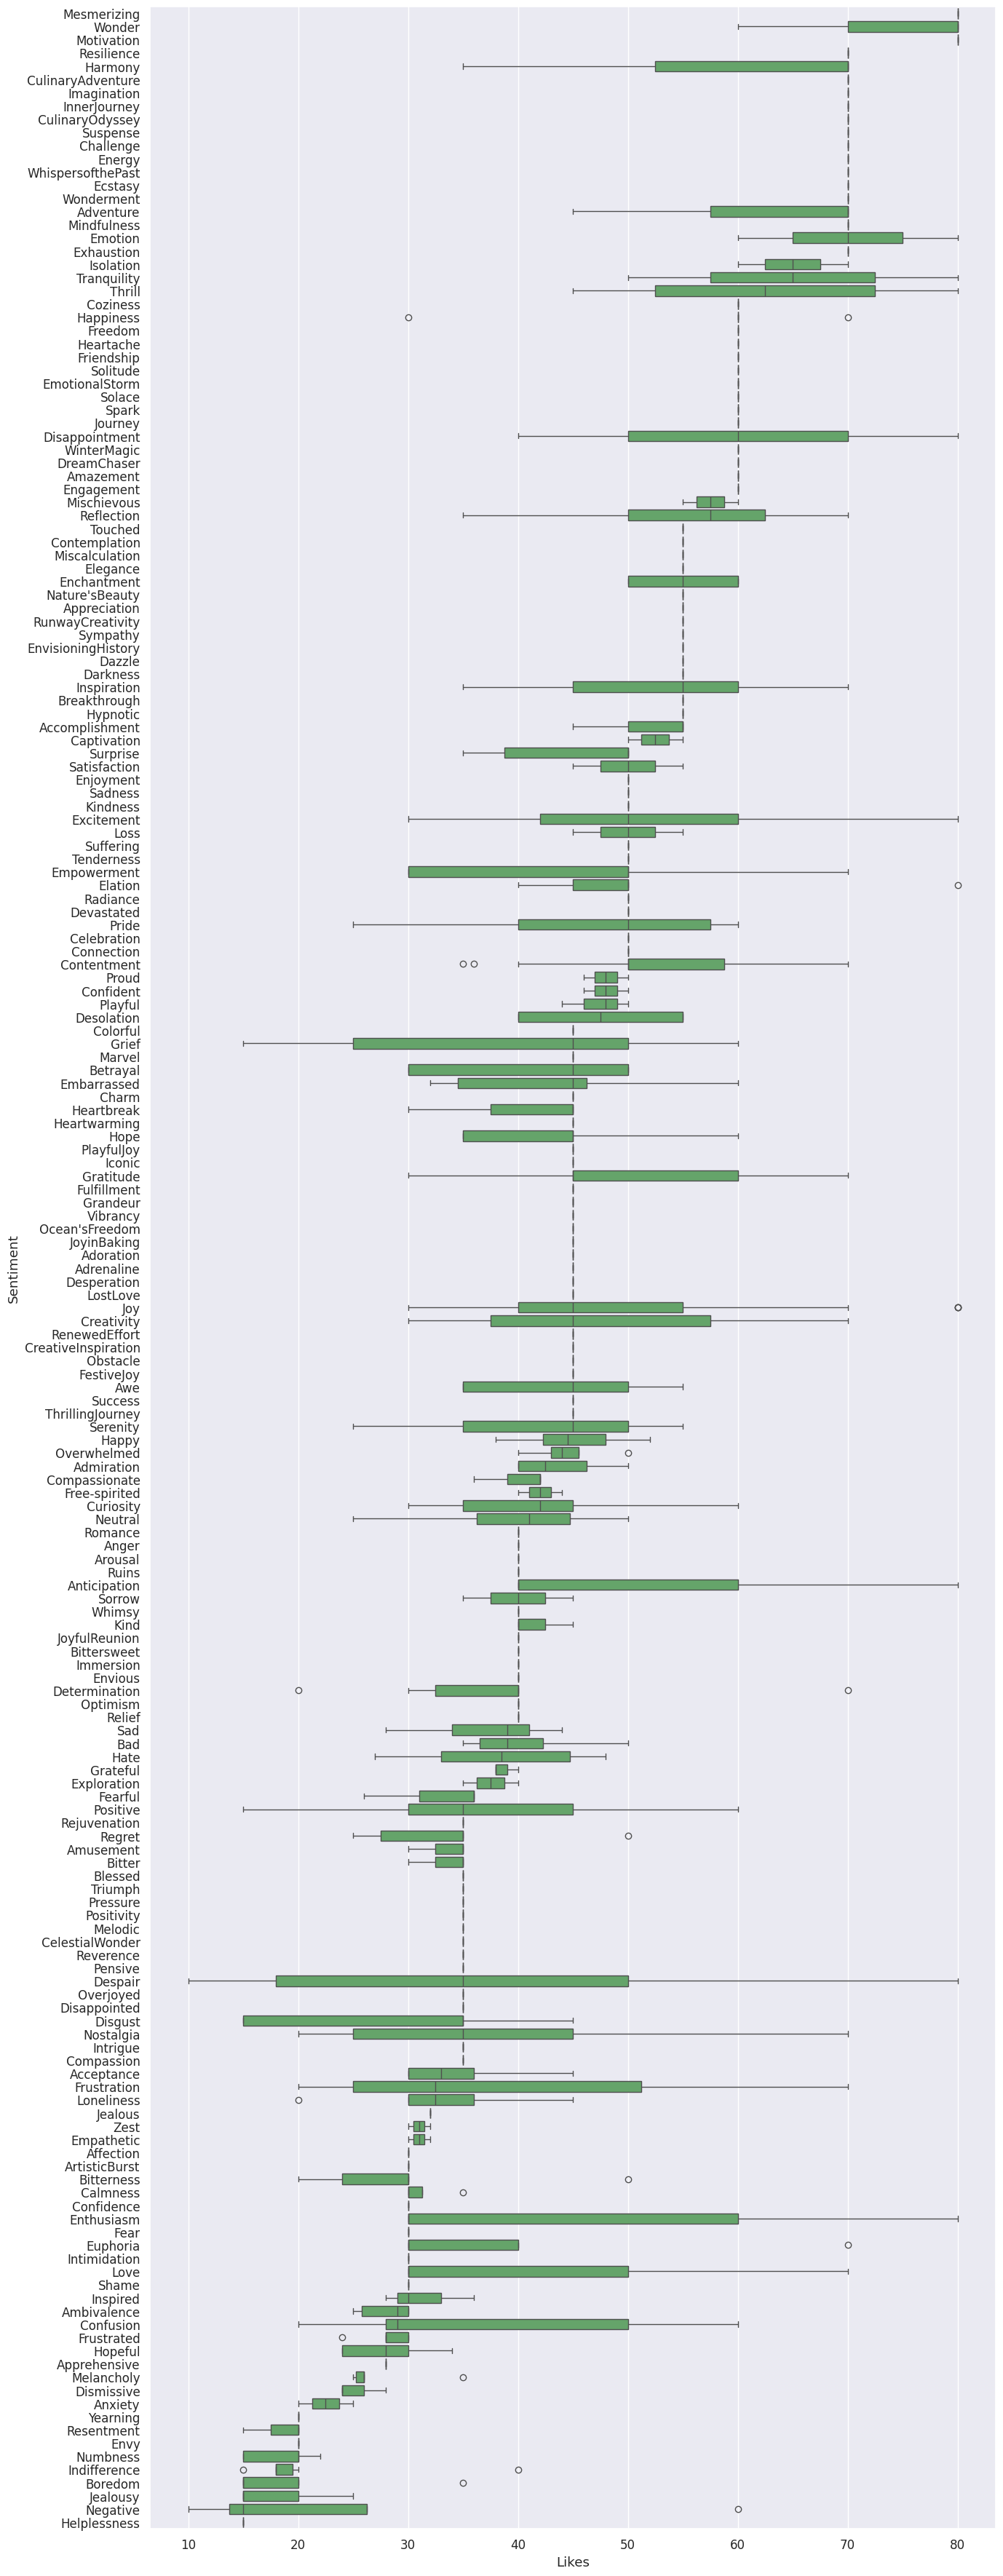

In [40]:
order = no_duplicated.groupby(['Sentiment']).Likes.median().sort_values(ascending=False).index

plt.figure(figsize=(15,45))
g = sns.boxplot(data=no_duplicated, y='Sentiment', x='Likes', color='#5AAE61', order=order)
#g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

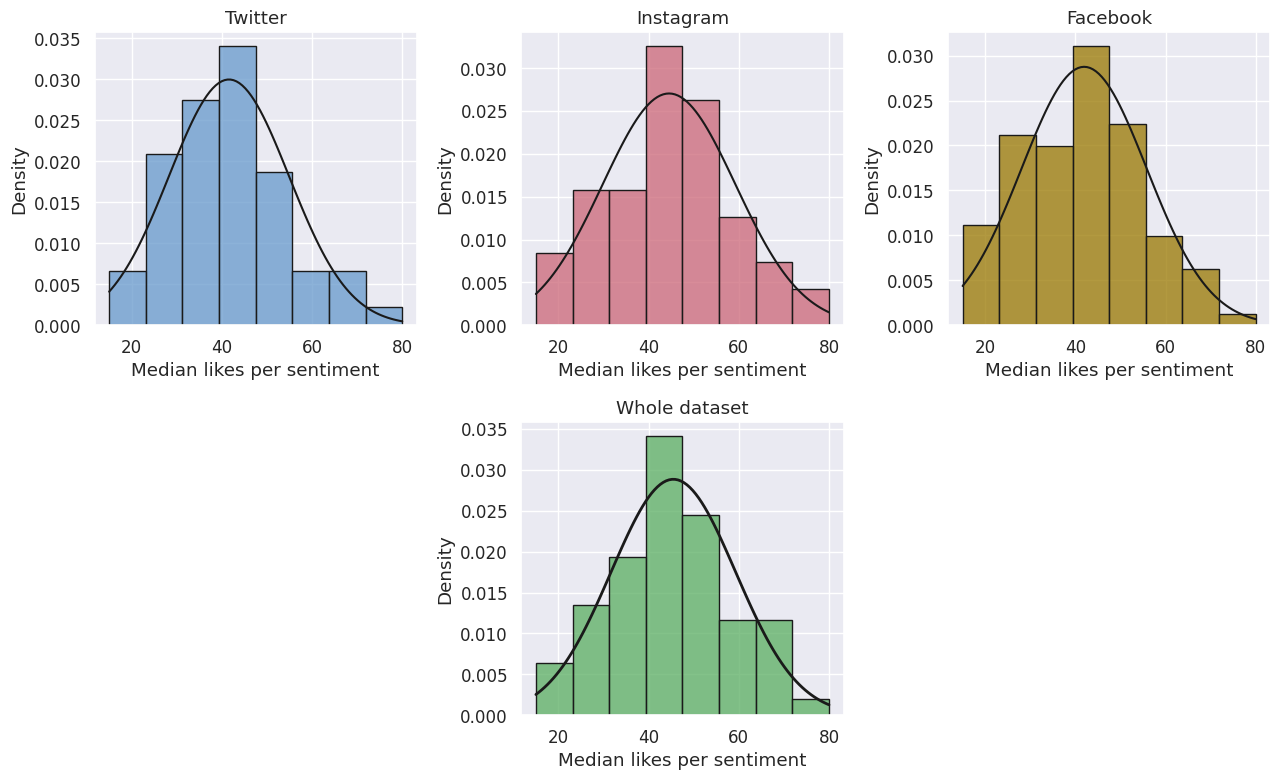

In [41]:
plt.figure(figsize=(13,8))
plt.subplot(2, 3, 1)
mu, std = norm.fit(twitter.groupby('Sentiment').Likes.median())
xmin, xmax = max(twitter.groupby('Sentiment').Likes.median()), min(twitter.groupby('Sentiment').Likes.median())
x = np.linspace(xmin, xmax, 100)
p_twitter = norm.pdf(x, mu, std)

ax1 = sns.histplot(twitter.groupby('Sentiment').Likes.median(),
                   bins=8, color='#6699CC',edgecolor='k',kde=False, stat= 'density')
plt.plot(x, p_twitter, c='k')
ax1.set_title('Twitter')
ax1.set_xlabel('Median likes per sentiment')
#############################
plt.subplot(2, 3, 2)

mu, std = norm.fit(instagram.groupby('Sentiment').Likes.median())
xmin, xmax = max(instagram.groupby('Sentiment').Likes.median()), min(instagram.groupby('Sentiment').Likes.median())
x = np.linspace(xmin, xmax, 100)
p_instagram = norm.pdf(x, mu, std)

ax2 = sns.histplot(instagram.groupby('Sentiment').Likes.median(),
                   color='#CC6677',edgecolor='k',kde=False, stat= 'density')
plt.plot(x, p_instagram, c='k')
ax2.set_xlabel('Median likes per sentiment')
ax2.set_title('Instagram')
##############################
plt.subplot(2, 3, 3)

mu, std = norm.fit(facebook.groupby('Sentiment').Likes.median())
xmin, xmax = max(facebook.groupby('Sentiment').Likes.median()), min(facebook.groupby('Sentiment').Likes.median())
x = np.linspace(xmin, xmax, 100)
p_facebook = norm.pdf(x, mu, std)

ax3 = sns.histplot(facebook.groupby('Sentiment').Likes.median(),
                   color='#997700',edgecolor='k',kde=False, stat= 'density')
plt.plot(x, p_facebook, c='k')
ax3.set_xlabel('Median likes per sentiment')
ax3.set_title('Facebook')
##############################
plt.subplot(2, 3, 5)

mu, std = norm.fit(no_duplicated.groupby('Sentiment').Likes.median())
xmin, xmax = max(no_duplicated.groupby('Sentiment').Likes.median()), min(no_duplicated.groupby('Sentiment').Likes.median())
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

ax4 = sns.histplot(no_duplicated.groupby('Sentiment').Likes.median(),
             bins=8, color='#5AAE61',edgecolor='k',kde=False, stat= 'density')
plt.plot(x, p, 'k', linewidth=2)
ax4.set_title('Whole dataset')
ax4.set_xlabel('Median likes per sentiment')

plt.tight_layout()

In [42]:
most_likes_sentiment = {'Whole':[], 'Twitter':[], 'Facebook':[], 'Instagram':[]}

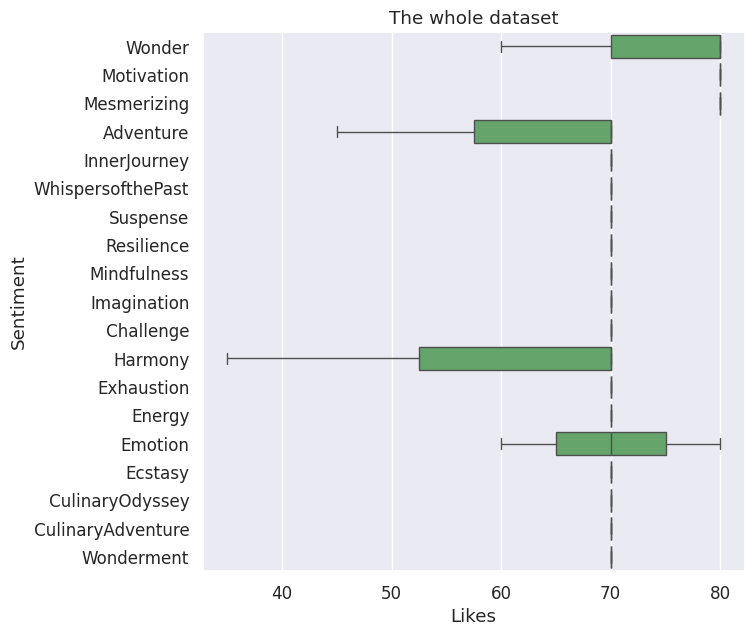

In [43]:
mean = mu
standard_deviation = std

distribution = norm(loc=mean,
                    scale=standard_deviation)

len_sentiment = no_duplicated.groupby('Sentiment').Likes.median().sort_values(ascending=False)
for sentiment, value in np.array([len_sentiment.index, len_sentiment.values]).T:
    if float(value) > distribution.ppf(0.9544):
        most_likes_sentiment['Whole'].append(sentiment)

most_likes_sentiment_db = no_duplicated[no_duplicated['Sentiment'].isin(most_likes_sentiment['Whole'])]
order_whole = most_likes_sentiment_db.groupby(['Sentiment']).Likes.median().sort_values(ascending=False).index

plt.figure(figsize=(7,7))
g = sns.boxplot(data=most_likes_sentiment_db, y='Sentiment', x='Likes',
                color='#5AAE61', order=order_whole)
plt.title('The whole dataset')
plt.show()

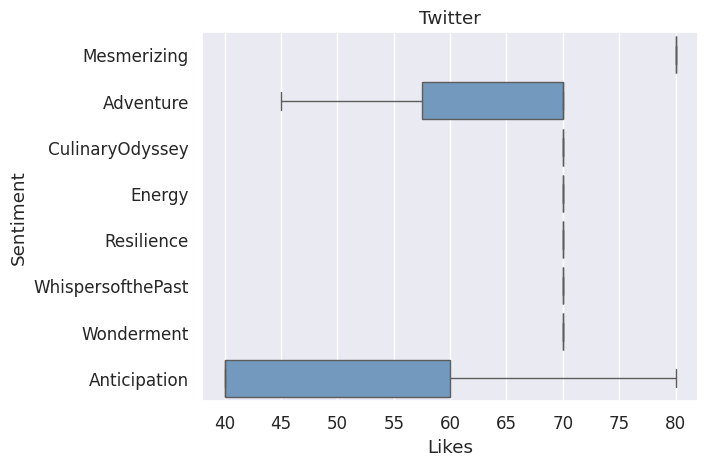

In [44]:

mean = mu
standard_deviation = std

distribution = norm(loc=mean,
                    scale=standard_deviation)

len_sentiment = twitter.groupby('Sentiment').Likes.median().sort_values(ascending=False)
for sentiment, value in np.array([len_sentiment.index, len_sentiment.values]).T:
    if float(value) > distribution.ppf(0.9544):
        most_likes_sentiment['Twitter'].append(sentiment)

most_likes_sentiment_twitter = no_duplicated[no_duplicated['Sentiment'].isin(most_likes_sentiment['Twitter'])]
order_twitter = most_likes_sentiment_twitter.groupby(['Sentiment']).Likes.median().sort_values(ascending=False).index

g = sns.boxplot(data=most_likes_sentiment_twitter, y='Sentiment', x='Likes',
                color='#6699CC', order=order_twitter)
plt.title('Twitter')
plt.show()

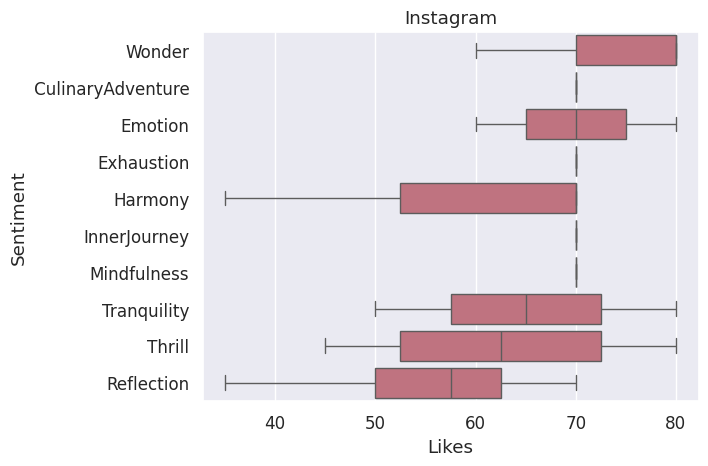

In [45]:
mu, std = norm.fit(instagram.groupby('Sentiment').Likes.median())
xmin, xmax = max(instagram.groupby('Sentiment').Likes.median()), min(instagram.groupby('Sentiment').Likes.median())
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

mean = mu
standard_deviation = std
distribution = norm(loc=mean,
                    scale=standard_deviation)


len_sentiment = instagram.groupby('Sentiment').Likes.median().sort_values(ascending=False)
for sentiment, value in np.array([len_sentiment.index, len_sentiment.values]).T:
    if float(value) > distribution.ppf(0.9544):
        most_likes_sentiment['Instagram'].append(sentiment)

most_likes_sentiment_instagram = no_duplicated[no_duplicated['Sentiment'].isin(most_likes_sentiment['Instagram'])]
order_instagram = most_likes_sentiment_instagram.groupby(['Sentiment']).Likes.median().sort_values(ascending=False).index

g = sns.boxplot(data=most_likes_sentiment_instagram, y='Sentiment', x='Likes',
                color='#CC6677', order=order_instagram)
plt.title('Instagram')
plt.show()


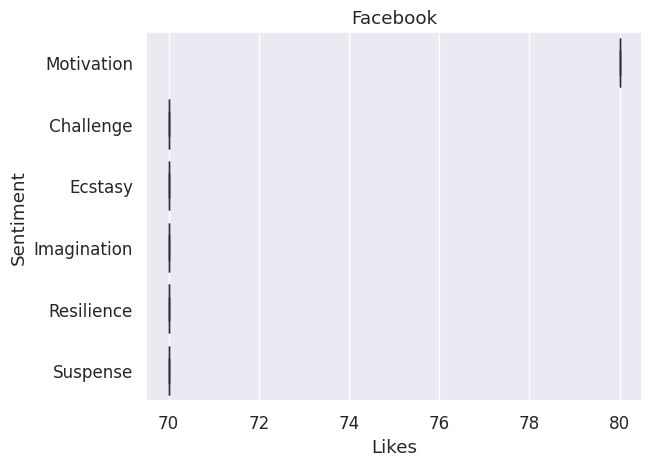

In [46]:
mu, std = norm.fit(facebook.groupby('Sentiment').Likes.median())
xmin, xmax = max(facebook.groupby('Sentiment').Likes.median()), min(facebook.groupby('Sentiment').Likes.median())
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

mean = mu
standard_deviation = std
distribution = norm(loc=mean,
                    scale=standard_deviation)

len_sentiment = facebook.groupby('Sentiment').Likes.median().sort_values(ascending=False)
for sentiment, value in np.array([len_sentiment.index, len_sentiment.values]).T:
    if float(value) > distribution.ppf(0.9544):
        most_likes_sentiment['Facebook'].append(sentiment)

most_likes_sentiment_facebook = no_duplicated[no_duplicated['Sentiment'].isin(most_likes_sentiment['Facebook'])]
order_facebook = most_likes_sentiment_facebook.groupby(['Sentiment']).Likes.median().sort_values(ascending=False).index

g = sns.boxplot(data=most_likes_sentiment_facebook, y='Sentiment', x='Likes',
                color='#997700', order=order_facebook)
plt.title('Facebook')
plt.show()


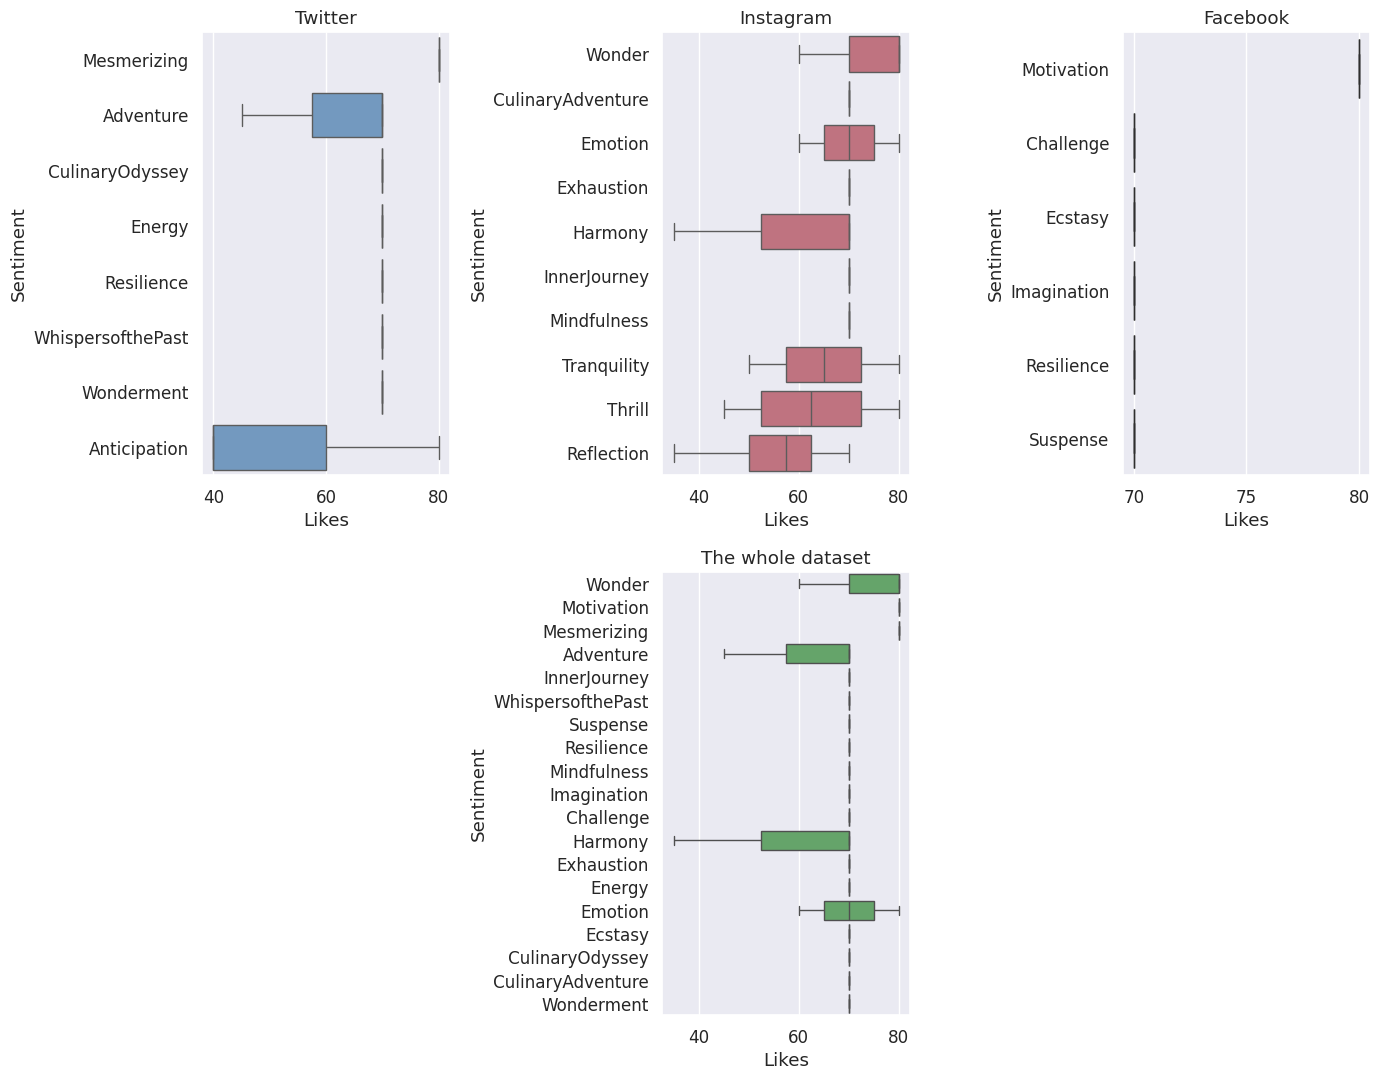

In [47]:
plt.figure(figsize=(14,11))
plt.subplot(2, 3, 1)
ax1 = sns.boxplot(data=most_likes_sentiment_twitter, y='Sentiment', x='Likes',
                color='#6699CC', order=order_twitter)
ax1.set_title('Twitter')
###########################
plt.subplot(2, 3, 2)
ax2 = sns.boxplot(data=most_likes_sentiment_instagram, y='Sentiment', x='Likes',
                color='#CC6677', order=order_instagram)
ax2.set_title('Instagram')
###########################
plt.subplot(2, 3, 3)
ax3 = sns.boxplot(data=most_likes_sentiment_facebook, y='Sentiment', x='Likes',
                color='#997700', order=order_facebook)
ax3.set_title('Facebook')
###########################
plt.subplot(2, 3, 5)
ax4 = sns.boxplot(data=most_likes_sentiment_db, y='Sentiment', x='Likes',
                    color='#5AAE61', order=order_whole)
ax4.set_title('The whole dataset')

plt.tight_layout()

In [52]:
no_duplicated.groupby('Sentiment').Likes.agg([len, min, max]).sort_values(by='len', ascending=False).head(23)

,len,min,max
Sentiment,,,
Positive,45,15,60
Joy,44,30,80
Excitement,37,30,80
Contentment,18,35,70
Neutral,18,25,50
Gratitude,17,30,70
Curiosity,16,30,60
Serenity,15,25,55
Happy,14,38,52


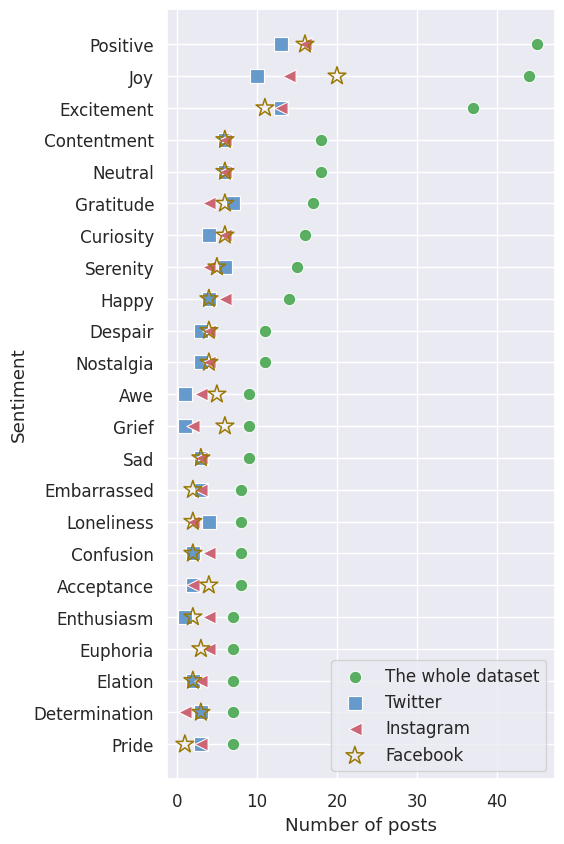

In [53]:
plt.figure(figsize=(5,10))
emotions = no_duplicated.groupby('Sentiment').Likes.agg(len).sort_values(ascending=False).head(23).index
most_posted_emotions = no_duplicated[no_duplicated['Sentiment'].isin(emotions)]
ax1 = sns.scatterplot(y=most_posted_emotions.groupby('Sentiment').Likes.agg(len).sort_values(ascending=False).index,
              x=most_posted_emotions.groupby('Sentiment').Likes.agg(len).sort_values(ascending=False).values,
              color='#5AAE61',
              s=80,
              label='The whole dataset'
             )

emotions_twitter = twitter.groupby('Sentiment').Likes.agg(len).sort_values(ascending=False).head(23).index
most_posted_emotions_twitter = twitter[twitter['Sentiment'].isin(emotions)]
ax2 = sns.scatterplot(y=most_posted_emotions_twitter.groupby('Sentiment').Likes.agg(len).sort_values(ascending=False).index,
              x=most_posted_emotions_twitter.groupby('Sentiment').Likes.agg(len).sort_values(ascending=False).values,
              color='#6699CC',
              s=110,
              marker='s',
              label='Twitter'
             )


emotions_instagram = instagram.groupby('Sentiment').Likes.agg(len).sort_values(ascending=False).head(23).index
most_posted_emotions_instagram = instagram[instagram['Sentiment'].isin(emotions)]
ax3 = sns.scatterplot(y=most_posted_emotions_instagram.groupby('Sentiment').Likes.agg(len).sort_values(ascending=False).index,
              x=most_posted_emotions_instagram.groupby('Sentiment').Likes.agg(len).sort_values(ascending=False).values,
              color='#CC6677',
              s=90,
              marker='<',
              label='Instagram'
             )

emotions_facebook = facebook.groupby('Sentiment').Likes.agg(len).sort_values(ascending=False).head(23).index
most_posted_emotions_facebook = facebook[facebook['Sentiment'].isin(emotions)]
ax4 = sns.scatterplot(y=most_posted_emotions_facebook.groupby('Sentiment').Likes.agg(len).sort_values(ascending=False).index,
              x=most_posted_emotions_facebook.groupby('Sentiment').Likes.agg(len).sort_values(ascending=False).values,
              color='#997700',
              s=180,
              marker='*',
              facecolors = 'none',
              edgecolor = '#997700',
              label='Facebook'
             )
plt.xlabel('Number of posts')
plt.legend()
plt.show()